In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import pickle
import numpy as np
import lightgbm as lgb

from os import listdir
from os.path import isfile, join

from scipy.stats import entropy
from scipy.special import softmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
from helper import *

from matplotlib import mlab
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/home/tryan/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#base batch_size=500
time_inference = {
    'resnet_18' : 0.043308353,
    'resnet_34' : 0.063735914,
    'resnet_50' : 0.114385653,
    'resnet_101' : 0.183127236,
    'nasnet_mobile' : 0.8923602104187012,
    'nasnet_large' : 5.196358609199524*2,
    'pnasnet_mobile' : 0.8181339502334595,
    'pnasnet_large' : 4.892335391044616*2,    
    
}
time_inference_cpu = {
    'resnet_18' : 1.012381005,
    'resnet_34' : 1.728078532,
    'resnet_50' : 2.145581436,
    'resnet_101' : 3.449709797,
    'nasnet_mobile' : 0.,
    'nasnet_large' : 0.,
    'pnasnet_mobile' : 0.,
    'pnasnet_large' : 0.,    
}

#base batch_size=1
# time_inference = {
#     'resnet_18' : 0.004326963,
#     'resnet_34' : 0.007118535,
#     'resnet_50' : 0.01020844,
#     'resnet_101' : 0.01618433,    
# }
# time_inference_cpu = {
#     'resnet_18' : 0.035453391,
#     'resnet_34' : 0.05855341,
#     'resnet_50' : 0.074465179,
#     'resnet_101' : 0.114496183,
# }

In [3]:
resnets = [18, 34, 50, 101]

logits = {}
accuracy_dict = {}

for i in resnets :
    net = 'resnet_' + str(i)
    l, acc = load_logit_acc(net, 'pred_'+str(i))
    print(net, np.mean(acc))
    logits[net] = l
    accuracy_dict[net] = acc

y_val_dict = {}
pred_dict = {}

for i in range(len(resnets)-1) :
    net1 = resnets[i]
    for j in range(i+1, len(resnets)) :
        net2 = resnets[j]
        merge_net_name = str(net2) + '_' + str(net1)
        saved_net_name = 'resnet_' + str(net1) + '_resnet_' + str(net2)
        y_pred, y_val = load_probability(merge_net_name)
        auc = roc_auc_score(y_val, y_pred)
        print(saved_net_name, auc)
        pred_dict[saved_net_name] = y_pred
        y_val_dict[saved_net_name] = y_val

resnet_18 0.6972
resnet_34 0.72984
resnet_50 0.75826
resnet_101 0.77266
resnet_18_resnet_34 0.8145272218110744
resnet_18_resnet_50 0.8233510095675672
resnet_18_resnet_101 0.8246405110531924
resnet_34_resnet_50 0.837726432268437
resnet_34_resnet_101 0.8391358313030646
resnet_50_resnet_101 0.8559524972474787


In [4]:
def evaluate(net1, net2, gpu=True) :
    accuracy1 = accuracy_dict[net1]
    accuracy2 = accuracy_dict[net2]
    
    y_pred = pred_dict[net1 + '_' + net2]
    y_val = y_val_dict[net1 + '_' + net2]

    if gpu :
        time_small = time_inference[net1]
        time_large = time_inference[net2]
    else :
        time_small = time_inference_cpu[net1]
        time_large = time_inference_cpu[net2]
        
    auc = roc_auc_score(y_val, y_pred)
    show_auc(y_val, y_pred)
    
    print(net1, np.mean(accuracy1), '+', net2, np.mean(accuracy2))
    print('AUC boosting', auc)   

    all_threshold, all_accuracy, all_speedup, passed_rate, val_01, val_10 = calculate_speedup(y_pred, 
                                                                                              accuracy1, accuracy2, 
                                                                                              time_small, time_large)
    
    show(all_threshold, all_accuracy, all_speedup, val_01, val_10)
    return all_threshold, all_accuracy, all_speedup, passed_rate, val_01, val_10

resnet_18 0.6972 + resnet_101 0.77266
AUC boosting 0.8246405110531924


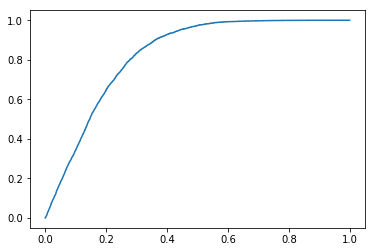

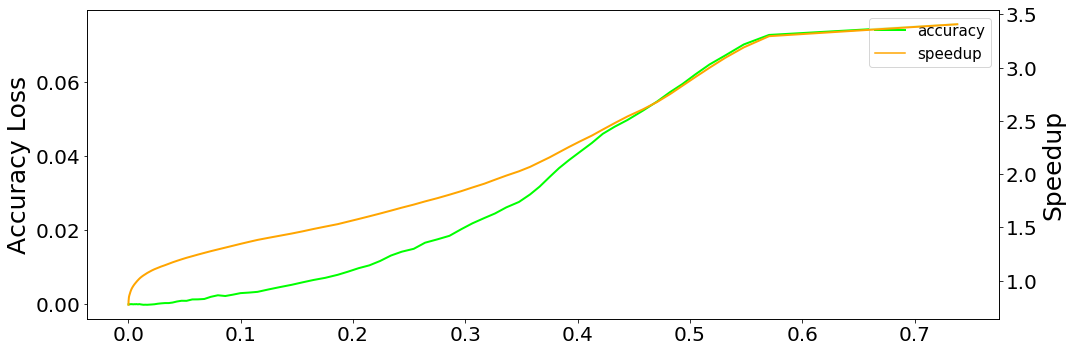

In [5]:
t, a, s, p, v01, v10 = evaluate('resnet_18', 'resnet_101', gpu=False)

In [6]:
stayed = np.argmax(s[a<=0.0209])
print(stayed/len(s), s[stayed], a[stayed])

0.75438 1.8550519704152635 0.02088000000000001


In [7]:
x = 0.9
idx = p>=x

In [8]:
s[idx][-1]

0.8378939515714274

In [10]:
a[idx][-1]

0.0

In [11]:
p[idx][-1]

0.9

In [12]:
v01[idx][-1]

0.11304

In [13]:
v10[idx][-1]

0.03758